In [1]:
from cytograph import Algorithm, creates, requires, div0
from cytograph.visualization.scatter import scatterc, scattern
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from typing import List
import shoji
import cytograph as cg
import cytograph.visualization as cgplot
import collections
from typing import List, Optional
import matplotlib.patheffects as PathEffects
import fastcluster
import igraph
import leidenalg as la
import scipy.cluster.hierarchy as hc
from hmmlearn import hmm
from openTSNE import TSNE
from pynndescent import NNDescent
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from tqdm import trange
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
from cytograph.visualization import Colorizer
from matplotlib.lines import Line2D
import scipy as sci
import scanpy as sc

In [2]:
db = shoji.connect()

In [498]:
%%time
ws = db.builds.jesper.GBM_Darmanis_raw
cg.NeftelStates().fit(ws, save=True)
#cgplot.PlotNeftel().fit(ws)
None

CPU times: user 5.69 s, sys: 1.32 s, total: 7.01 s
Wall time: 8.28 s


CPU times: user 173 ms, sys: 26 ms, total: 199 ms
Wall time: 273 ms


[Text(0, 0, 'Periphery'), Text(0, 1, 'Center')]

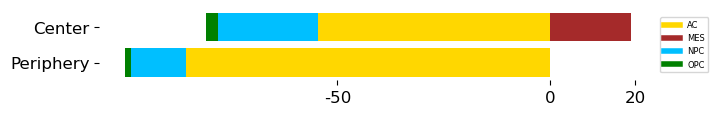

In [85]:
%%time
S = []
ws = db.builds.jesper.GBM_Darmanis_raw
Samples = ['Center', 'Periphery']
unique_samples = Samples
Samples = np.array(Samples, dtype=object)
Samples = np.flip(Samples)
unique_samples = np.array(unique_samples, dtype=object)
unique_samples = np.flip(unique_samples)
A = ['AC', 'MES', 'NPC', 'OPC']
labels = np.array(A, dtype=object)
for i, sample in enumerate(Samples):
    ac, mes, npc, opc = np.hsplit(ws.NeftelScore[ws.Zone[:] == sample][ws.Celltype[ws.Zone[:] == sample] == 'Tumor'], 4)
    winnersAll = np.argmax([ac, mes, npc, opc], axis=0)
    Man = np.hstack(labels[winnersAll])
    Sum = []
    for x in labels:
        Sum.append(np.sum(np.isin(Man, x)))
    Percent = []
    tot = np.sum(Sum)
    for x in Sum:
        roundedNumber = round(x/tot * 100, 1)
        Perc = str(roundedNumber) + "%"
        Percent.append(roundedNumber)
    size = np.array(Percent)
    S.append(size)
df = pd.DataFrame(S, columns=labels,  index=unique_samples)
nontumor_bars = df.drop('MES', axis=1)
tumor_bars = df[["MES"]]
left = np.zeros(len(unique_samples))
#fig, axes = plt.subplots(figsize=(2, 10) , nrows = 2, ncols = 1,sharex=True, gridspec_kw={'height_ratios': [2, 2 ]})
fig, ax1 = plt.subplots(figsize=(6, len(Samples)*0.5))
fig.tight_layout(pad=0)
#ax1 = axes[0]
#ax1.axis('off')
ax1.spines[['top','bottom','left', 'right']].set_visible(False)
ax1.set_xticks([-50,0,20])
ax1.xaxis.set_visible(True) 
#ax1.yaxis.set_visible(True) 

ax1.set_xticklabels([-50,0,20],fontsize=12)
colors=["gold", "brown", "deepskyblue", "green"]
pcolors = dict(zip(labels, colors))

for i, ct in enumerate(nontumor_bars):
    #ax1.bar(unique_samples,height=-nontumor_bars[ct],bottom=-bottom, color=palette_classes[ct])
    #bottom += nontumor_bars[ct]
    ax1.barh(unique_samples,height=0.8, width=-nontumor_bars[ct],left=-left, color=pcolors[ct])
    left += nontumor_bars[ct]
for i, ct in enumerate(tumor_bars):
    #ax1.bar(unique_samples,height=tumor_bars[ct],bottom=0, color=palette_classes[ct])
    ax1.barh(unique_samples, height=0.8, width=tumor_bars[ct],left=0, color=pcolors[ct])
hidden_lines = [Line2D([0], [0], color=clr, lw=4) for clr in colors]
ax1.legend(hidden_lines,labels, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=6)
ax1.set_yticklabels(unique_samples, fontsize=12) 
#plt.savefig("/proj/cytograph/jesper/Figures/Fig1_Darmanis/Metamodules.pdf", dpi=300, bbox_inches="tight")

In [11]:
ws = db.builds.jesper.GBM_Darmanis


In [4]:
MES1 = np.array(["CHI3L1","ANXA2","ANXA1","CD44","VIM","MT2A","C1S","NAMPT","EFEMP1","C1R","SOD2","IFITM3","TIMP1","SPP1","A2M","S100A11","MT1X","S100A10","FN1","LGALS1","S100A16","CLIC1","MGST1","RCAN1","TAGLN2","NPC2","SERPING1","TCIM","EMP1","APOE","CTSB","C3","LGALS3","MT1E","EMP3","SERPINA3","ACTN1","PRDX6","IGFBP7","SERPINE1","PLP2","MGP","CLIC4","GFPT2","GSN","NNMT","TUBA1C","GJA1","TNFRSF1A","WWTR1"])
MES2 = np.array(["HILPDA","ADM","DDIT3","NDRG1","HERPUD1","DNAJB9","TRIB3","ENO2","AKAP12","SQSTM1","MT1X","ATF3","NAMPT","NRN1","SLC2A1","BNIP3","LGALS3","INSIG2","IGFBP3","PPP1R15A","VIM","PLOD2","GBE1","SLC2A3","FTL","WARS1","ERO1A","XPOT","HSPA5","GDF15","ANXA2","EPAS1","LDHA","P4HA1","SERTAD1","PFKP","PGK1","EGLN3","SLC6A6","CA9","BNIP3L","RPL21","TRAM1","UFM1","ASNS","GOLT1B","ANGPTL4","SLC39A14","CDKN1A","HSPA9"])
gene_list = np.concatenate((MES1, MES2))
_, i = np.unique(gene_list, return_index=True)
gene_list = gene_list[np.sort(i)]
gene_list

array(['CHI3L1', 'ANXA2', 'ANXA1', 'CD44', 'VIM', 'MT2A', 'C1S', 'NAMPT',
       'EFEMP1', 'C1R', 'SOD2', 'IFITM3', 'TIMP1', 'SPP1', 'A2M',
       'S100A11', 'MT1X', 'S100A10', 'FN1', 'LGALS1', 'S100A16', 'CLIC1',
       'MGST1', 'RCAN1', 'TAGLN2', 'NPC2', 'SERPING1', 'TCIM', 'EMP1',
       'APOE', 'CTSB', 'C3', 'LGALS3', 'MT1E', 'EMP3', 'SERPINA3',
       'ACTN1', 'PRDX6', 'IGFBP7', 'SERPINE1', 'PLP2', 'MGP', 'CLIC4',
       'GFPT2', 'GSN', 'NNMT', 'TUBA1C', 'GJA1', 'TNFRSF1A', 'WWTR1',
       'HILPDA', 'ADM', 'DDIT3', 'NDRG1', 'HERPUD1', 'DNAJB9', 'TRIB3',
       'ENO2', 'AKAP12', 'SQSTM1', 'ATF3', 'NRN1', 'SLC2A1', 'BNIP3',
       'INSIG2', 'IGFBP3', 'PPP1R15A', 'PLOD2', 'GBE1', 'SLC2A3', 'FTL',
       'WARS1', 'ERO1A', 'XPOT', 'HSPA5', 'GDF15', 'EPAS1', 'LDHA',
       'P4HA1', 'SERTAD1', 'PFKP', 'PGK1', 'EGLN3', 'SLC6A6', 'CA9',
       'BNIP3L', 'RPL21', 'TRAM1', 'UFM1', 'ASNS', 'GOLT1B', 'ANGPTL4',
       'SLC39A14', 'CDKN1A', 'HSPA9'], dtype='<U8')

In [5]:
Samples = ['Necrotic core', 'High', 'Low', 'No', 'Cortex']

In [9]:
celltype = ['Tumor','TAM']

CPU times: user 1min 49s, sys: 24.1 s, total: 2min 13s
Wall time: 3min 13s


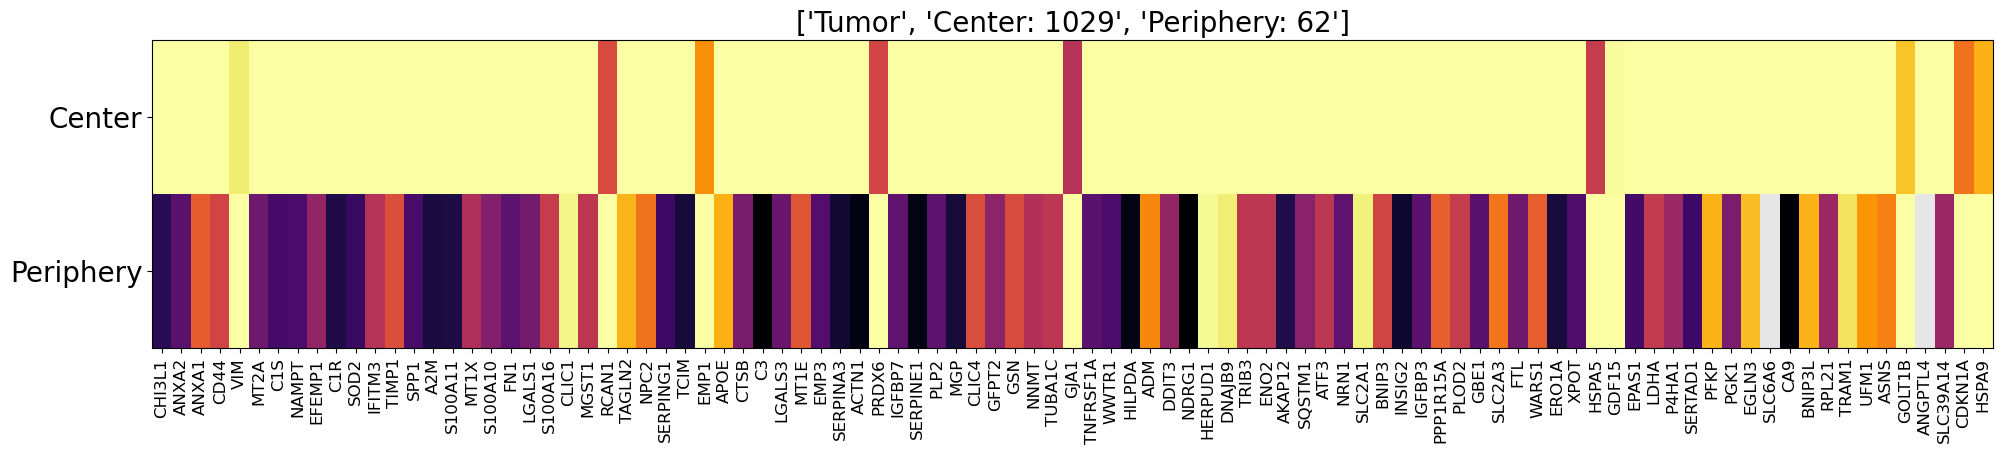

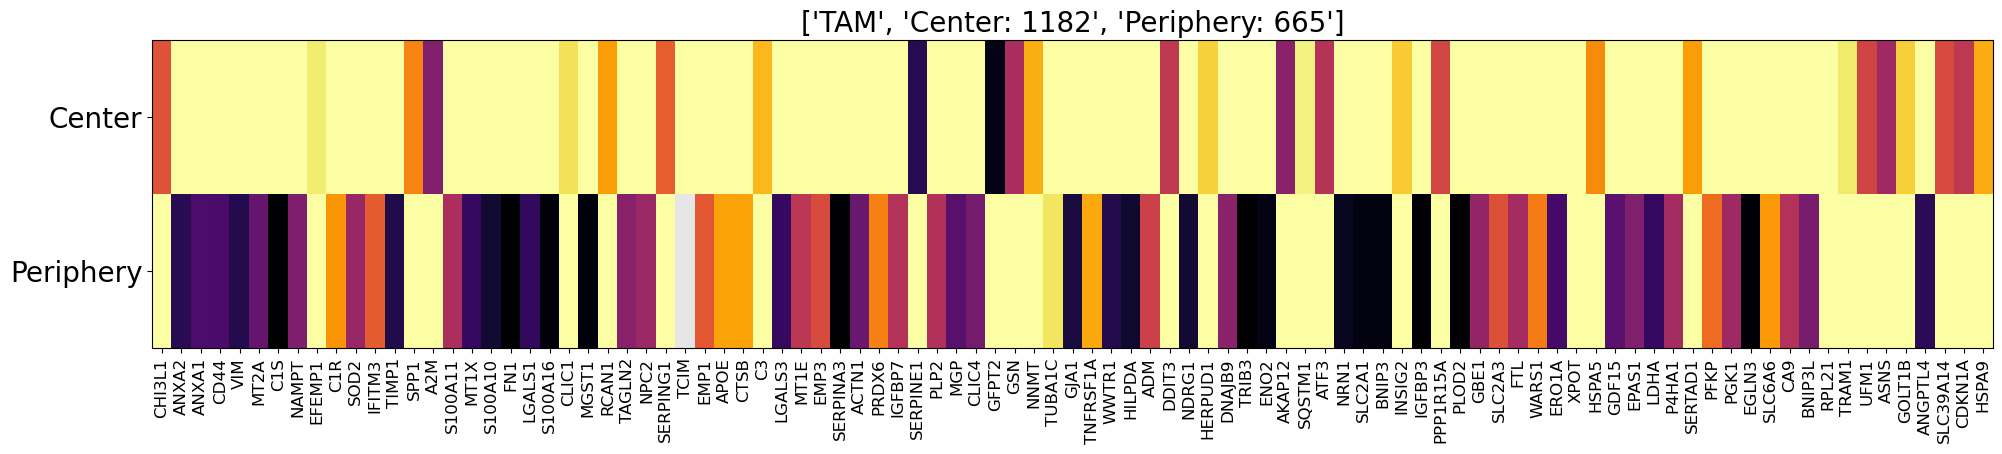

In [10]:
%%time
#Heatmap for all cell types, normalized internally
#celltype = np.unique(ws.Celltype[:])
Samples = ['Center', 'Periphery']
Samples = np.array(Samples, dtype=object)
for cell in celltype:
    Sum = [cell]
    unique_samples = []
    for i, sample in enumerate(Samples):
        Su = np.sum(ws.Celltype[ws.Zone[:] == sample] == cell)
        Sum.append(sample + ": " + str(Su))
        if Su > 0:
            unique_samples.append(sample)
    n_genes = len(gene_list)
    n_clusters = len(unique_samples)
    x = np.zeros((n_genes, n_clusters))
    for i, gene in enumerate(gene_list):
        gene_ix = np.where(ws.Gene[:] == gene)[0][0]
        for n, sample in enumerate(unique_samples):
            x[i, n] = np.mean(ws.Expression_nolog2[:, ws.Gene == str(gene)][ws.Zone[:] == sample][ws.Celltype[ws.Zone[:] == sample] == cell])

    # Normalize
    totals = x.sum(axis=1)
    xY = (x.T / totals * np.median(totals)).T
    xY = cg.div0(xY.T, np.percentile(xY, 99.5, axis=1)).T

    # Make background grey for zeros
    xY = xY.T
    G = xY
    bg = np.zeros_like(xY) + 0.9
    xY = np.ma.masked_where(xY == 0, xY)
    plt.figure(None, (n_genes / 4, 4))
    plt.imshow(bg[:], vmin=0, vmax=1, cmap=plt.cm.gray, aspect="auto")
    plt.imshow(xY[:], cmap="inferno", vmax=1, interpolation= "nearest", aspect="auto", alpha=1)
    plt.xticks(ticks=range(n_genes),labels=gene_list, fontsize=12, rotation=90)
    plt.yticks(ticks=range(n_clusters), labels=unique_samples, fontsize=20)
    plt.title(list(Sum),fontsize=20)
    #plt.colorbar()
    None
    #plt.savefig("/proj/cytograph/jesper/Figures/Suppl/Heatmap_MES_" + cell + ".pdf",dpi=300, bbox_inches="tight")

In [15]:
ws = db.builds.jesper.GBM_Darmanis_raw

In [16]:
adata = ws.create_anndata()

In [17]:
adata

AnnData object with n_obs × n_vars = 3589 × 59480
    obs: 'Celltype', 'Cluster_2d', 'Cluster_2d_color', 'ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'Location', 'Location_color', 'Multimapping_reads_percent', 'NeftelClass', 'Non_ERCC_reads', 'Sample_name', 'Sample_name_color', 'Sample_type', 'Sample_type_color', 'Selection', 'Selection_color', 'Splice_sites_AT_AC', 'Splice_sites_Annotated', 'Splice_sites_GC_AG', 'Splice_sites_GT_AG', 'Splice_sites_non_canonical', 'Splice_sites_total', 'TotalUMIs', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Unmapped_mismatch', 'Unmapped_other', 'Unmapped_short', 'Zone'
    var: 'Chromosome', 'End', 'Gene', 'GeneTotalUMIs', 'Start'

In [18]:
adata.var.index
adata.var.Gene
adata.var = adata.var.set_index('Gene')
adata.var.index = adata.var.index.astype('object')
adata.var_names_make_unique()
adata.var.index.is_unique

True

In [19]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata, base=2)

In [20]:
samples = ['Center']

                                      Tumor


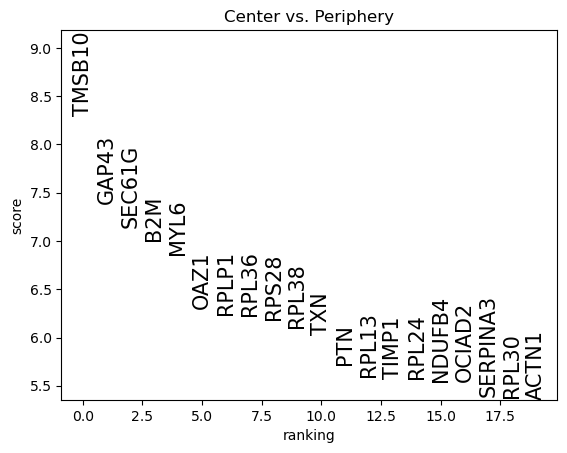

                                      TAM


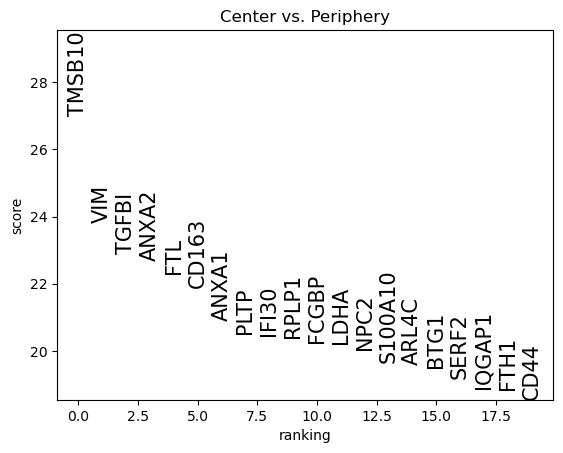

In [22]:
for cell in celltype:
    cells = adata[adata.obs['Celltype'] == cell,:]
    unique_samples = []
    for sample in samples:
        Su = np.sum(ws.Celltype[ws.Zone[:] == sample] == cell)
        if Su > 0:
            unique_samples.append(sample)
    for samp in unique_samples:
        sc.tl.rank_genes_groups(cells, 'Zone', groups=[samp], reference='Periphery', method="wilcoxon")
        print('                                      ' + cell)
        sc.pl.rank_genes_groups(cells, groups=[samp], n_genes=20, fontsize=15) 

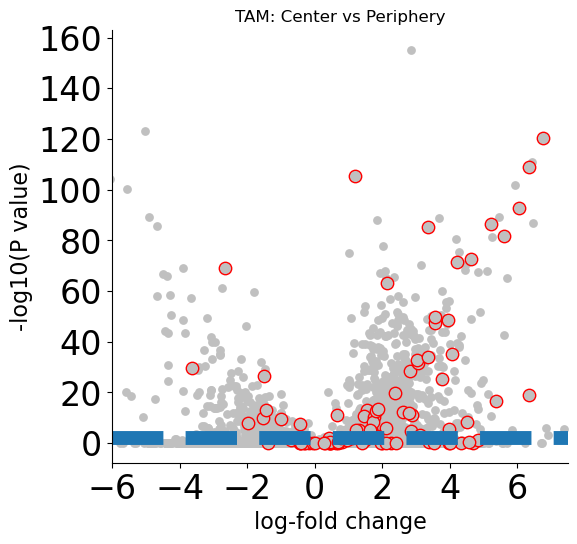

In [26]:
celltype = ['TAM']
plt.figure(None, (20, 100))
gs = plt.GridSpec(15, 3)
i = 0
for cell in celltype:
    cells = adata[adata.obs['Celltype'] == cell,:]
    unique_samples = []
    for sample in samples:
        Su = np.sum(ws.Celltype[ws.Zone[:] == sample] == cell)
        if Su > 0:
            unique_samples.append(sample)
    for samp in unique_samples:
        sc.tl.rank_genes_groups(cells, 'Zone', groups=[samp], reference='Periphery', method="wilcoxon")
        gene_rank = sc.get.rank_genes_groups_df(cells, group=samp)#[['names','logfoldchanges','pvals', 'pvals_adj']]
        ax = plt.subplot(gs[i])
        x = gene_rank['logfoldchanges']
        y = np.copy(gene_rank['pvals_adj'])
        # setting to less than 1e-300 makes np.log10 inf
        y[y == 0] = 1e-300
        y = -np.log10(y)
        plt.scatter(x, y, s=40, lw=0, color='silver')
        plt.hlines(-np.log10(1e-2), -6, 7.5, linestyles='dashed', lw=10)
        #for g in ['HES1', 'IRX5', 'LHX2', 'NELL1', 'PAX3']:
        for g in gene_list:
            ix = gene_rank['names'] == g
            plt.scatter(x[ix], y[ix], s=80, lw=1, color='silver', edgecolors='r')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        plt.xlim(-6, 7.5)
        #plt.ylim(0, 5)
        plt.ylabel("-log10(P value)",fontsize=16)
        plt.xlabel("log-fold change", fontsize=16)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.title(cell + ": " + samp + ' vs Periphery')
        i += 1

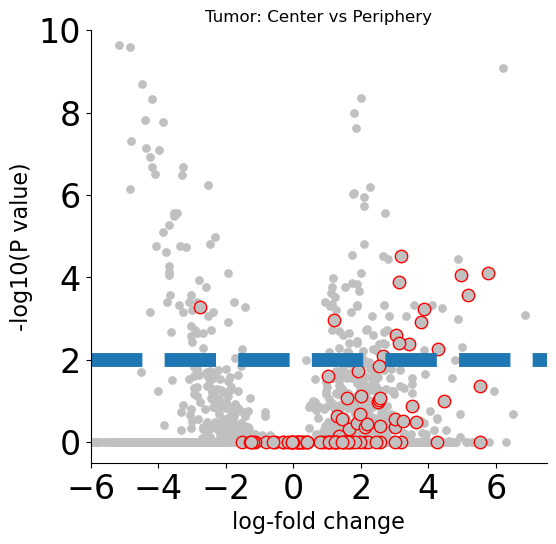

In [28]:
celltype = ['Tumor']
plt.figure(None, (20, 100))
gs = plt.GridSpec(15, 3)
i = 0
for cell in celltype:
    cells = adata[adata.obs['Celltype'] == cell,:]
    unique_samples = []
    for sample in samples:
        Su = np.sum(ws.Celltype[ws.Zone[:] == sample] == cell)
        if Su > 0:
            unique_samples.append(sample)
    for samp in unique_samples:
        sc.tl.rank_genes_groups(cells, 'Zone', groups=[samp], reference='Periphery', method="wilcoxon")
        gene_rank = sc.get.rank_genes_groups_df(cells, group=samp)#[['names','logfoldchanges','pvals', 'pvals_adj']]
        ax = plt.subplot(gs[i])
        x = gene_rank['logfoldchanges']
        y = np.copy(gene_rank['pvals_adj'])
        # setting to less than 1e-300 makes np.log10 inf
        y[y == 0] = 1e-300
        y = -np.log10(y)
        plt.scatter(x, y, s=40, lw=0, color='silver')
        plt.hlines(-np.log10(1e-2), -6, 7.5, linestyles='dashed', lw=10)
        #for g in ['HES1', 'IRX5', 'LHX2', 'NELL1', 'PAX3']:
        for g in gene_list:
            ix = gene_rank['names'] == g
            plt.scatter(x[ix], y[ix], s=80, lw=1, color='silver', edgecolors='r')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        plt.xlim(-6, 7.5)
        plt.ylim(-0.5, 10)
        plt.ylabel("-log10(P value)",fontsize=16)
        plt.xlabel("log-fold change", fontsize=16)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.title(cell + ": " + samp + ' vs Periphery')
        i += 1